# Conducting Sentiment Analysis on Mental Health Data

This project focuses on classifying mental health statuses for various statements. The dataset is a valuable resource for performing sentiment analysis and developing mental health applications. It comprises a large collection of text statements sourced from various online platforms (including Reddit and Twitter) and is meticulously tagged with one of seven mental health statuses: Normal, Depression, Suicidal, Anxiety, Stress, Bi-Polar, and Personality Disorder. This diverse and cleaned data is ideal for training machine learning models to understand and predict mental health conditions from text, enabling the development of intelligent chatbots and facilitating research into mental health trends and help with early detection of mental health conditions, saving time and money for healthcare providers. 

We will now install the necessary libraries and packages to do this project. 

In [1]:
# import packages
!pip install wordcloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Defaulting to user installation because normal site-packages is not writeable


# MDLC Step Loading the Data

We will now load the dataset into our notebook. 

In [2]:
# change working directory
import os
os.getcwd()  # Get current working directory
os.chdir('..')  # Move up one directory level from notebooks
print(os.getcwd())
#os.chdir('../data') # change to the data folder

/home/jupyter-geean/cookiecutter-data-science/{{ cookiecutter.repo_name }}


In [3]:
# load the data
df = pd.read_csv('data/Combined Data.csv', index_col=0)


# MDLC Step: EDA and Train-Test Split

We will now conduct exploratory data analysis to learn more about our dataset and decide on the data preprocessing steps we need to take based on this exploratory data analysis. 

Many of the rows have NaNs and represent anxiety and normal. Since there are 53,043 values and there are only 362 rows where there is missing values. We feel that it is best to drop these rows since they represent only 0.7% of the data and as you will see later we have an abundance of "normal" and "anxiety" labeled data.

In [4]:
# calculate the number of missing values
rows_with_missing = df[df.isnull().any(axis=1)]
print(rows_with_missing)

      statement   status
293         NaN  Anxiety
572         NaN  Anxiety
595         NaN  Anxiety
1539        NaN   Normal
2448        NaN   Normal
...         ...      ...
52838       NaN  Anxiety
52870       NaN  Anxiety
52936       NaN  Anxiety
53010       NaN  Anxiety
53031       NaN  Anxiety

[362 rows x 2 columns]


In [5]:
# make a copy and get rid of the missing values
df1 = df.copy()
df1.dropna(inplace = True)
# see the top head of the data
df1.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


The dataset includes 52,681 rows and 2 columns after removing missing values.

 We want to add a column to explore the length of each statement. This can help us quantify the user's input and support further analysis. This will give us an idea on how to preprocess the text and determine tokenization especially for transformer models. Many NLP models, especially those based on deep learning, have limitations on input length so determining the length is important.

In [6]:
# create a new column that gives the length of each statement
df1['statement_len'] = df1['statement'].apply(lambda x: len(x.split(' ')))
df1.head()

,statement,status,statement_len
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14
3,I've shifted my focus to something else but I'...,Anxiety,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14


From the output, we can see that this dataset includes 2 variables: statement and status.

The statement variable is a text variable that contains different user inputs.

The status variable represents different emotional statuses, which contain different categories.

The next step is to explore dataset

In [7]:
# information about the dataset
'''The class type of the DataFrame.
The range of the index.
The number of columns and their names.
The count of non-null values in each column.
The data type of each column.
The memory usage of the DataFrame.'''

print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   statement      52681 non-null  object
 1   status         52681 non-null  object
 2   statement_len  52681 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB
None


Statement and status column are object data types. The statement_len column is an integer/numeric datatype.

The summary statistics for the 'Statement_len' column show the distribution of statment lengths. The average statement contains 113 words with a standard deviation of 163.5 words. The shortest statement only has 1 word, while the longest contains 6300 words. The most frequent statement length is 5 words, indicating that short phrases are commonly used.

The following bar plot of the frequency of statement length visualizes the previous statement.

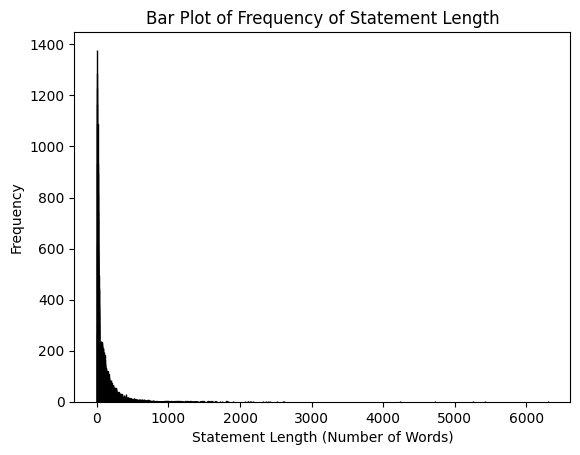

In [8]:
# Create a bar plot of the frequency of the 'statement_len' column
statement_len_counts = df1['statement_len'].value_counts()

plt.bar(statement_len_counts.index, statement_len_counts.values, edgecolor='black')
plt.xlabel('Statement Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Bar Plot of Frequency of Statement Length')
plt.show()

The histogram shows that it is a right skewed distribution, which most of the statement length under 1000 words.
This means that when we focus on the output length, we should set it to be under 1000.

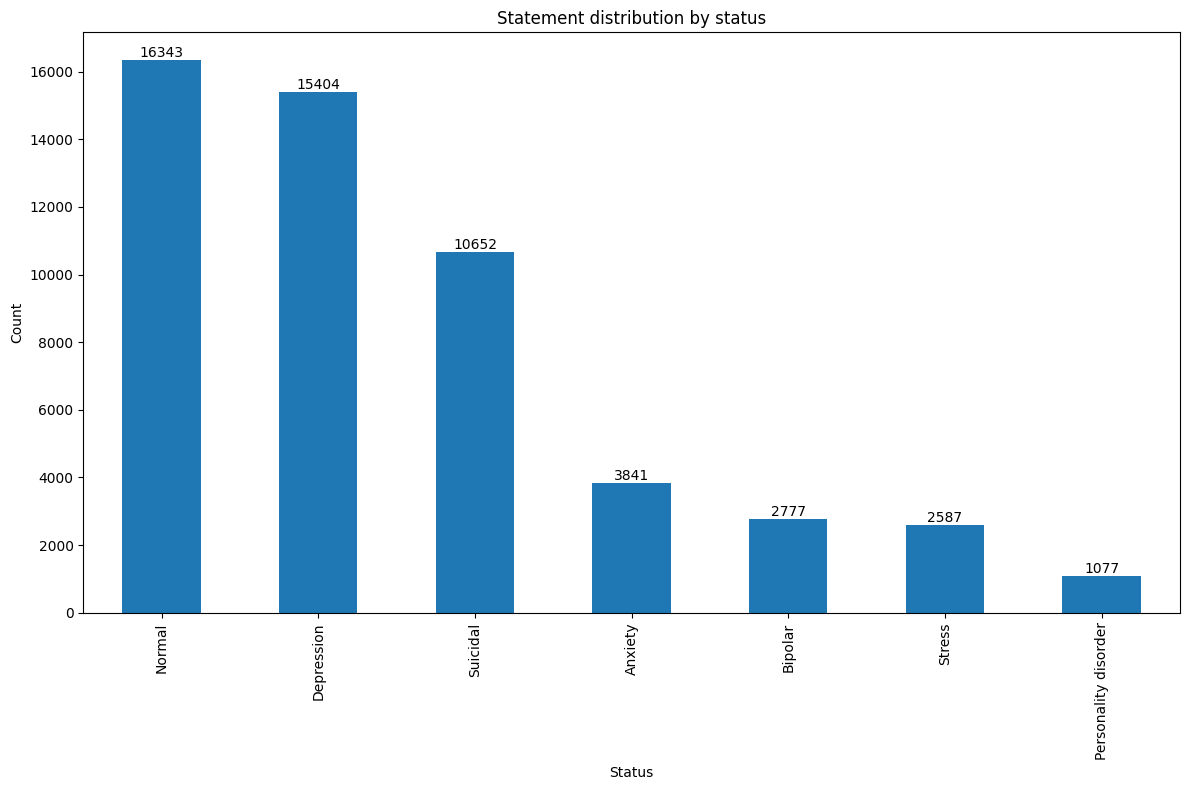

In [9]:
# Histogram of Frequency of Statements by Status
plt.figure(figsize=(12,8))

# get the unique status values and their counts
status_counts = df1['status'].value_counts()

# create the bar plot
ax = status_counts.plot(kind='bar')

# add the count labels on top of each bar
for i, v in enumerate(status_counts):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Statement distribution by status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Here is a plot showing distribution by status. Normal is the most common status and contains 16343 data, followed by depression and suicidal, which are the 2nd and 3rd largest portions of the dataset. Personality disorder is the most rare one, which contains 1077 data.

The ratio between different statuses suggests about 70% of the user's input falls under the negative status category.

The target variable in our dataset is unbalanced in favor of depression, suicidal and normal. This imbalance could affect our model's performance, so we'll need to address it later to ensure accurate and fair predictions especially when predicting sentiment analysis for anxiety, bipolar, stress and personality disorder.

In [10]:
# Taking a look at the long messages
df1[df1['statement_len'] > 1500]

,statement,status,statement_len
7851,So introduction I guess.. my name is Michael a...,Depression,2153
8221,do not really know where to start so I am goin...,Depression,1602
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,2139
10743,"ThrowawayIm female, 20 years old. Ever since I...",Depression,1537
10834,I have only 1 person I can somewhat open to bu...,Suicidal,5248
11537,"The title is not meant to discourage others, b...",Depression,2391
11581,I no longer know what else to do but write thi...,Depression,2612
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,2415
11831,Sorry this is long but I doubt anyone will eve...,Depression,2187
13188,I am frustrated. that is the constant theme wi...,Depression,1832


Many of the longest messages are those with depression and suicidal tendencies. This will help us since if we shorten the output length when preprocessing the data, we are not reducing the number of data points for those that do not have very many data points such as anxiety, bipolar, stress and personality disorder.

Now we want to see a clearer distribution without these outliers so that we can determine the best output length for preprocessing the text.

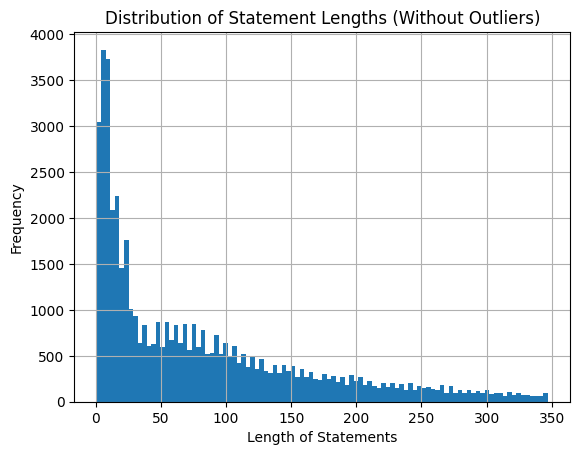

In [11]:
# Statement Length Distribution Without Outliers
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df1['statement_len'].quantile(0.25)
Q3 = df1['statement_len'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df1[(df1['statement_len'] >= lower_bound) & (df1['statement_len'] <= upper_bound)]
# Plot the distribution of statement lengths without outliers
filtered_df['statement_len'].hist(bins=100)
plt.title('Distribution of Statement Lengths (Without Outliers)')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

This distrubtion still shows a right-skewed data distribution. We now have a much clearer distribution where approximately 50% of the statements have 0-50 word lengths, especially with a spike at approximately 25 words with approximately 3700 statements. This will help us immensely to determine the best statement length to run our transformer models to save computational resources and time but not decrease model performance.

Now we want to take a closer look at the word clouds for each status since it will give us even more information about the possible word indicators for each status.  

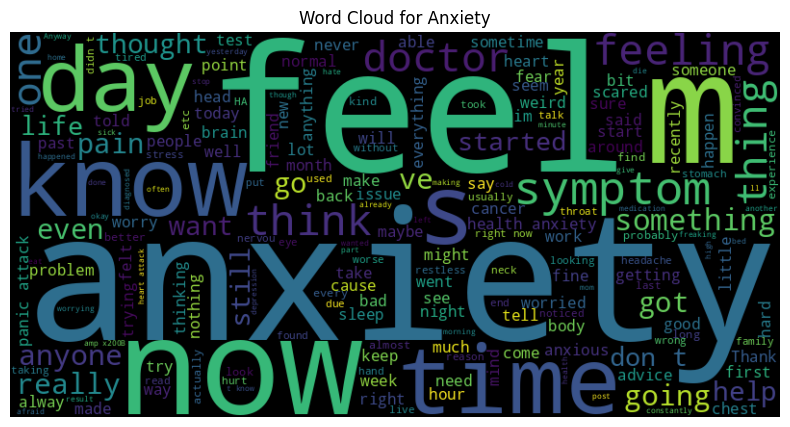

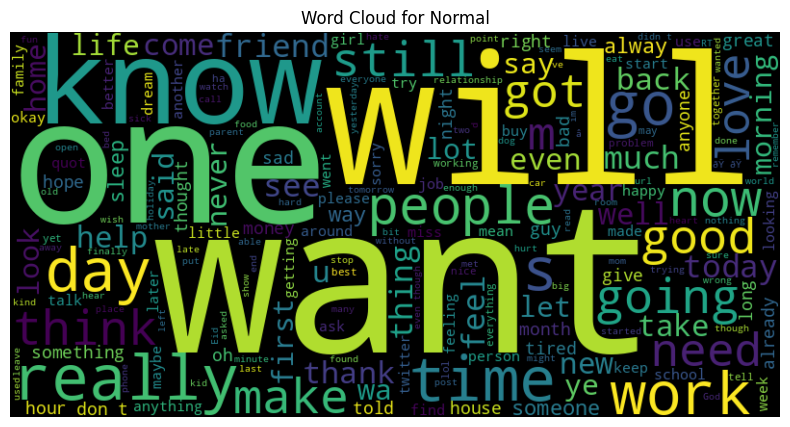

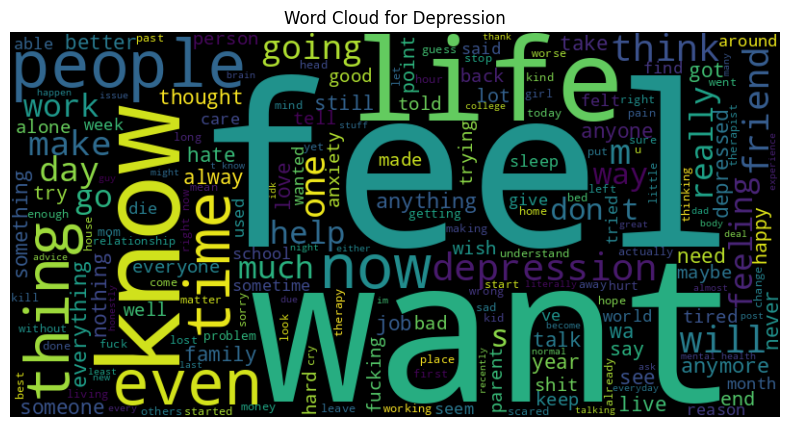

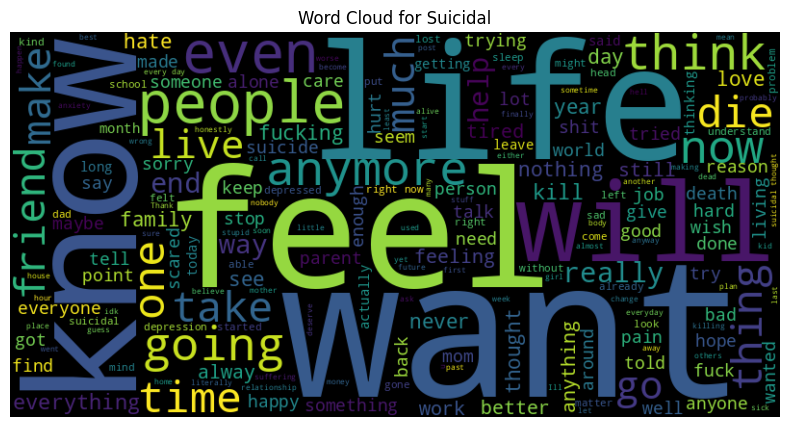

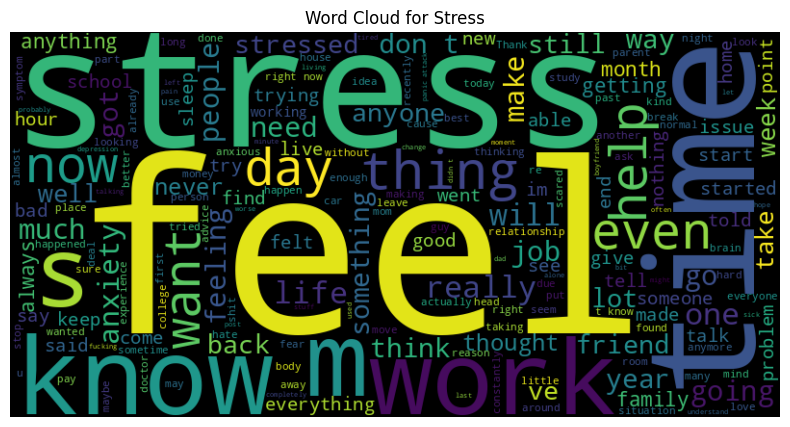

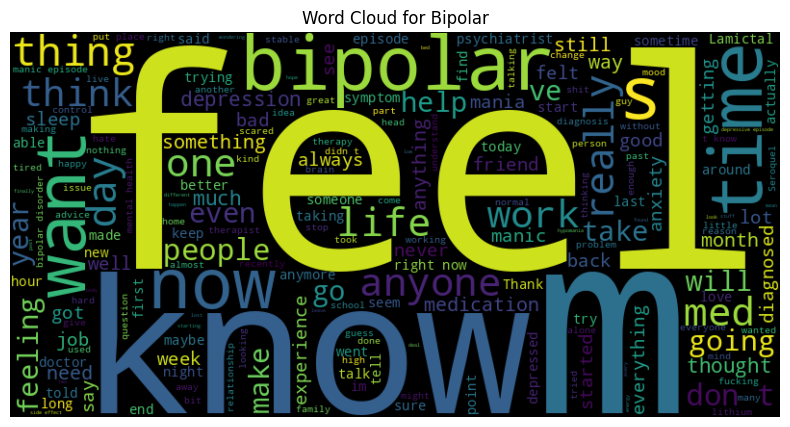

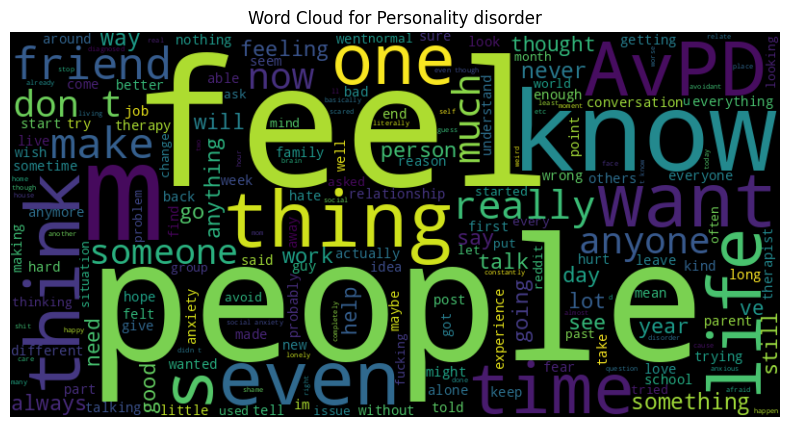

In [12]:
# Create a function to generate and display a word cloud
def generate_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Generate word clouds for each status
statuses = df1['status'].unique()

for status in statuses:
    status_text = ' '.join(df1[df1['status'] == status]['statement'])
    generate_word_cloud(status_text, title=f'Word Cloud for {status}')

# MDLC Step Preprocessing the data

Based on the exploratory data analysis and mental health context, we can now start to preprocess the data. We will conduct the usual preprocessing techniques when it comes to natural language processing (NLP) such as stemming, removing punctuation and writing all lowercase.

Notes: 
df1 is the dataframe that does not have any of the missing values.
filtered_df is the dataframe with the outliers removed and no missing values. We will keep the outliers since sentiment analysis often has extreme reviews (e.g., very short or long ones) that can hold strong emotions, valuable for classification especially when using non-transformer models. For transformer models, we may remove outliers by shortening the word length input or use filtered_df to reduce computational time without sacrificing performance. For now, we will use df1 to preprocess the data. Transformer models tend to have different preprocessing techniques anyways. 

⚠ **Warning:** After installing `imbalanced-learn`, please **restart the kernel** for the changes to take effect.  

You can do this in Jupyter Notebook by clicking:  
**Kernel** → **Restart Kernel**


In [13]:
# install packages 
!pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable


In [14]:
# import packages
import seaborn as sns

import re
import random
from imblearn.over_sampling import RandomOverSampler # used for oversampling
from scipy.sparse import hstack, csr_matrix  # To combine sparse matrices

import nltk # nlp package
nltk.download('punkt') # install punkt tokenizer
from nltk.tokenize import word_tokenize # tokenize the text
from nltk.stem import PorterStemmer # stem the text

from sklearn.feature_extraction.text import TfidfVectorizer # used for tf-idf
from sklearn.model_selection import GridSearchCV # used to find the best parameters
from sklearn.preprocessing import LabelEncoder # used to encode categorical variables


[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     geean/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
# Remove duplicates based on 'statement'
df_unique = df1.drop_duplicates(subset=['statement'])

df_unique.head()

,statement,status,statement_len
0,oh my gosh,Anxiety,3
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14
3,I've shifted my focus to something else but I'...,Anxiety,11
4,"I'm restless and restless, it's been a month n...",Anxiety,14


## Why Add Sentence & Character Length in NLP?

Enhancing NLP models like **Naïve Bayes** and **XGBoost** with numerical metadata (e.g., sentence length, character count) improves performance by capturing structural insights.

### 🚀 Benefits:
- **Structural Insights**  
  - **Sentence Length**: Differentiates concise vs. verbose texts (e.g., tweets vs. articles).  
  - **Character Length**: Indicates complexity, verbosity, or spam tendencies.  

- **Better Model Interpretability**  
  - Helps tree-based models (e.g., XGBoost) make effective splits.  
  - Useful for readability assessment, spam detection, and authorship identification.  

- **Performance Boost**  
  - Combines well with TF-IDF, embeddings, and n-grams.  
  - Provides independent signals, improving classification accuracy.  

### 🎯 Key Use Cases:
- **Sentiment Analysis**: Short reviews are often more direct (positive/negative).  


In [16]:
# Calculate the number of characters and sentences
# install nltk downloader punkt_tab for sentences
nltk.download('punkt_tab')

df_unique['num_of_characters'] = df_unique['statement'].str.len()
df_unique['num_of_sentences'] = df_unique['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = df_unique[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

[nltk_data] Downloading package punkt_tab to /home/jupyter-
[nltk_data]     geean/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


       num_of_characters  num_of_sentences
count       51073.000000      51073.000000
mean          575.375051          6.249251
std           847.661079         10.762749
min             2.000000          1.000000
25%            79.000000          1.000000
50%           313.000000          3.000000
75%           745.000000          8.000000
max         32759.000000       1260.000000


## Text Preprocessing

### Convert to lowercase for uniformity

In [17]:
# convert to lowercase
#rename columns
df_unique.rename(columns={'statement': 'original_statement'}, inplace=True)  

# create a new cleaned statement column called statement
df_unique['statement']=df_unique['original_statement'].str.lower()
# see the first ten rows
df_unique.head()

,original_statement,status,statement_len,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,3,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,11,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,2,"i'm restless and restless, it's been a month n..."


### Remove URLS and other text, punctuation, and special text
To remove specific patterns such as URLs or other unwanted text (like ```[View Poll](https://www.reddit.com/poll/...)```) from a column in a pandas DataFrame, we can use regular expressions with the re module or pandas built-in string methods. This will help us get cleaner relevant text.

In [18]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df_unique['statement'] = df_unique['statement'].apply(remove_patterns)
# see the first ten rows
df_unique.head()

,original_statement,status,statement_len,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,3,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,2,im restless and restless its been a month now ...


### Tokenization 
This is when the statements are split into words/tokens.
Tokenization is **essential in NLP** as it breaks text into smaller units (tokens), making it **processable by models** like Naïve Bayes, XGBoost, and Transformers.

### 🔹 Key Benefits  
- **Structures Raw Text** → Converts unstructured text into a usable format.  
- **Boosts Model Performance** → Enables better text classification, sentiment analysis, etc.  
- **Handles Language Variability**  
  - **Word-based**: `"I love NLP"` → `["I", "love", "NLP"]`  
  - **Subword-based (BPE, WordPiece)**: `"unhappiness"` → `["un", "happiness"]`  
  - **Character-based**: Useful for languages without spaces (e.g., Chinese).  
- **Improves Efficiency** → Reduces complexity for machine learning models.    


In [19]:
# Apply word_tokenize to each element in the 'statement' column
df_unique['tokens'] = df_unique['statement'].apply(word_tokenize)
# see the first ten rows
df_unique.head()

,original_statement,status,statement_len,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,3,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,11,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


## 🌱 What is Stemming & Why is it Important in NLP?

**Stemming** reduces words to their root form by removing prefixes/suffixes, helping **normalize text** and **reduce dimensionality** in NLP.

### 🔹 How It Works  
- `"running"` → `"run"`  
- `"happily"` → `"happi"`  
- `"flies"` → `"fli"`  

### 🔥 Why It Matters  
- **Reduces Vocabulary Size** → Groups similar words.  
- **Boosts Search & NLP Models** → `"run"` and `"running"` treated alike.  
- **Speeds Up Processing** → Fewer unique tokens.  

### ⚠️ Limitation  
- Can produce **incorrect roots** (`"better"` → `"bet"`).  
- **Lemmatization** (more accurate) uses a dictionary.  

### 🎯 Takeaway  
Stemming **simplifies text, reduces redundancy, and improves efficiency** in NLP. 🚀  


In [20]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df_unique['tokens_stemmed'] = df_unique['tokens'].apply(stem_tokens)

# print the first ten rows
df_unique.head()


,original_statement,status,statement_len,num_of_characters,num_of_sentences,statement,tokens,tokens_stemmed
0,oh my gosh,Anxiety,3,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,11,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,"I'm restless and restless, it's been a month n...",Anxiety,14,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


##  Not Removing Stop Words

Stop words are **frequent words** that may not carry significant meaning in NLP tasks.  

### 📝 **General Stop Words**  
- **Articles** → *a, an, the*  
- **Prepositions** → *in, on, at, by, with*  
- **Pronouns** → *I, you, he, she, it, they*  
- **Conjunctions** → *and, but, or, so*  
- **Auxiliary Verbs** → *is, are, was, were, have, do, does*  

For **mental health sentiment analysis**, it's best to **keep stop words** because:  

### 🔹 Context Matters  
- Words like **"not," "never," "very"** can flip sentiment.  
  - *"not okay"* ≠ *"okay"*  

### 🔹 Emotional Expressions  
- Stop words are essential for capturing **feelings and emotions**.  
  - *"I feel so lost"* carries more meaning than *"feel lost"*.  

We can see from the word clouds that there are not many stop words that are in bold so we will not remove them.  


In [21]:
# Now we create our dataset for train-validation-test adding the numerical features

In [22]:
X = df_unique[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df_unique['status']

## 🔠 Why Use Label Encoding for Categorical Variables?  

Label encoding converts **categorical target variables (Y)** into numerical format for machine learning models.  

### 🔹 Why is it Necessary?  
- **ML Models Require Numeric Input** → Algorithms like **XGBoost, Naïve Bayes, SVM** can’t process text labels.  
- **Standardizes Target Variable** → Maps categories to integers (*e.g., "positive" → 2, "neutral" → 1, "negative" → 0*).  
- **Compatible with Many Models** → Needed for both **classification** and **regression tasks**.  


In [23]:
# label encode our categorical variables for y 
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

# MDLC Step Train-Validation-Test Split

Most common splits are 80-20 so we will use this split here. We will also create a validation set that is 10% and the test set is 10%. The final splits will be 80-10-10.

I did these splits, since this is a common split in machine learning and data science but also because with 80% of the data as a training dataset, a large portion ensures that the model has enough data to learn from, which helps in capturing the underlying patterns and relationships in the data. With a Validation Set of 10%, it can tune hyperparameters and make decisions about the model architecture and helps prevent overfitting by providing a checkpoint to evaluate the model's performance on unseen data during the training process. With a 10% Test Set, we can evaluate the model's performance after it has been trained and validated and 10% is a large enough size given that we have approximately 50,000 data points. The 80-10-10 split is a balanced approach that ensures the model has sufficient data for training while also providing enough data for validation and testing to ensure robust performance

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temporary (20%) sets
train_x, temp_x, train_y, temp_y = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary set into validation (50%) and test (50%) sets
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.5, random_state=42)

# Print the sizes of the splits
print(f"Training set size: {len(train_x)}")
print(f"Validation set size: {len(val_x)}")
print(f"Test set size: {len(test_x)}")


Training set size: 40858
Validation set size: 5107
Test set size: 5108


# MDLC Step Feature Engineering, Data Augmentation and Reducing Dimensionality

We created the number of sentences and the character length as new features from the "statement" column earlier. 

Since we only had "statement" column to begin with, we did not need to reduce dimensionality from our original dataset. However, we decided to remove statement_length from the data since these are very similar to number of characters and number of sentences.

Enhancing NLP models like Naïve Bayes and XGBoost with numerical metadata significantly improves performance by capturing valuable structural insights.  Sentence length, for example, differentiates concise texts like tweets from verbose articles.  Character count can indicate text complexity, verbosity, or even spam tendencies.  These structural features not only offer better model interpretability, aiding tree-based models like XGBoost in making effective splits, but also boost overall performance.  This metadata combines well with traditional NLP features like TF-IDF, embeddings, and n-grams, providing independent signals that enhance classification accuracy.  Applications include readability assessment, spam detection, and even authorship identification, demonstrating the broad utility of incorporating numerical metadata into NLP workflows.

### Convert Text to Features using tf-idf to reduce dimensionality

Now, we will transform tokens (words) into numerical values that represent the importance of words in a document relative to a collection of documents. This helps highlight unique words in a document while downplaying common ones, making it easier for machine learning models to identify relevant patterns and make better predictions.

TF-IDF plays a crucial role in sentiment analysis by weighting the importance of words within a document relative to the entire collection of documents (corpus).  While it doesn't strictly *reduce* dimensionality like PCA by eliminating features (words), it effectively manages complexity by assigning weights that reflect a word's relevance.  Term Frequency (TF) measures how often a word appears in a specific document, while Inverse Document Frequency (IDF) quantifies how rare that word is across the corpus.  Common words like "the" or "a" appear frequently in almost all documents, resulting in low IDF scores.  Conversely, words that appear frequently in some documents but rarely elsewhere have high IDF scores.  The TF-IDF score, the product of TF and IDF, reflects the overall importance of a word in a particular document within the larger context of the corpus.

This weighting scheme is key to sentiment analysis because it downplays the influence of common, often uninformative words that contribute little to sentiment.  These words, while frequent, are essentially noise.  At the same time, TF-IDF highlights the words that are most discriminative of sentiment, those that appear frequently in documents expressing a particular sentiment but rarely elsewhere.  By emphasizing these key terms, TF-IDF effectively reduces the impact of less relevant dimensions (words), allowing sentiment analysis models to focus on the most informative features.  This leads to improved performance by making the model more robust to the curse of dimensionality, even though the actual number of features isn't reduced.  In short, TF-IDF acts as a feature weighting mechanism, prioritizing the signal (sentiment indicators) over the noise (common words).


In [25]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens_stemmed' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(train_x['tokens_stemmed'])
X_val_tfidf = vectorizer.transform(val_x['tokens_stemmed'])
test_x_tfidf = vectorizer.transform(test_x['tokens_stemmed'])

# 3. Numerical Feature Extraction
X_train_num = csr_matrix(train_x[['num_of_characters', 'num_of_sentences']].values)
X_val_num = csr_matrix(val_x[['num_of_characters', 'num_of_sentences']].values)
test_x_num = csr_matrix(test_x[['num_of_characters', 'num_of_sentences']].values)

# 4. Combine Features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_val_combined = hstack([X_val_tfidf, X_val_num])
test_x_combined = hstack([test_x_tfidf, test_x_num])

# Print number of feature words
print('Number of feature words:', len(vectorizer.get_feature_names_out()))


Number of feature words: 50000


In [26]:
X_train_combined.shape

(40858, 50002)

## ⚖️ Why Oversampling for an Imbalanced Dataset?  

In an **imbalanced dataset**, the model may favor the majority class, leading to **biased predictions**. **Oversampling** helps balance the dataset by increasing minority class samples.

### 🔹 Why is Oversampling Needed?  
- **Prevents Majority Class Bias** → Ensures the model learns patterns from both classes.  
- **Improves Model Performance** → Leads to better recall, F1-score, and generalization.  
- **Enhances Minority Class Representation** → Avoids underestimating rare but important cases.

### 🔥 Why Does Random Over-Sampling Work Best?   
✅ **Maintains Original Data Distribution** → Simply duplicates minority class samples, avoiding synthetic noise (SMOTE).  
✅ **Preserves Minority Class Variability** → Unlike SMOTE, which may create unrealistic synthetic samples.  
✅ **Avoids Data Loss** → Unlike Under-Sampling, which removes majority class samples and risks losing valuable information.


In [27]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined,train_y)

In [28]:
# see the new dataset
X_train_resampled.shape

(89215, 50002)

# MDLC Step Choosing the Best Model

We found that XGBoost was the best model for conducting sentiment analysis. 

# Why Use XGBoost for Sentiment Analysis in Mental Health?  

## 1. **Handles Imbalanced Data Well**  
Mental health sentiment datasets often have class imbalances (e.g., more neutral or non-anxious posts than highly anxious ones). XGBoost provides:  
- `scale_pos_weight` to balance classes  
- Custom loss functions to focus on minority class performance  

## 2. **Captures Complex Relationships**  
Mental health sentiment is influenced by nuanced language patterns, and XGBoost can:  
- Identify **non-linear** interactions between words and context  
- Work well with **engineered features** (e.g., TF-IDF scores, sentiment polarity, linguistic cues)  

## 3. **Works Well with Sparse Data**  
- Sentiment features (TF-IDF, word embeddings) are typically **high-dimensional and sparse**.  
- XGBoost efficiently handles sparse matrices with the `gpu_hist` tree method, making it fast even on large text datasets.  

## 4. **Robust to Noisy Data**  
- Mental health text data often contains **spelling errors, slang, and abbreviations**.  
- XGBoost's regularization (`reg_alpha`, `reg_lambda`) helps prevent overfitting on noisy text features.  

## 5. **Fast and Scalable**  
- XGBoost is optimized for **parallel computation** and can leverage GPUs for faster training.  
- It **scales well** to large datasets, making it ideal for **social media sentiment analysis**.  

## 6. **Feature Importance & Interpretability**  
- Unlike deep learning models, XGBoost provides **feature importance scores**, helping explain **which words or features impact mental health sentiment predictions**.  
- This interpretability is crucial for mental health professionals who need actionable insights.  

## 7. **Effective with Ensemble Methods**  
- Can be combined with **logistic regression, LSTMs, or BERT-based models** for improved sentiment classification.  
- Hybrid approaches like **XGBoost + Embeddings** can yield strong performance on mental health text data.  

---

### ✅ **Conclusion**  
XGBoost is a **powerful, efficient, and interpretable** model for **sentiment analysis in mental health**, especially when working with **engineered text features** like TF-IDF or word embeddings. It effectively handles imbalanced, sparse, and noisy data while providing insights into key predictive features. 🚀  

## Explanation of the Best XGBoost Model

**3. XGB_Fastest**

* **`learning_rate=0.2`**: This is a relatively high learning rate, allowing the model to converge even faster.
* **`max_depth=3`**: Same as the other models.
* **`n_estimators=200`**: Same number of trees as the other models.
* **`subsample=0.7` and `colsample_bytree=0.7`**: Same as the "Faster" model.
* **`reg_alpha=1` and `reg_lambda=1`**: Same as the "Faster" model.
* **`tree_method='hist'`**: Same as the other models.
* **Intended Effect**: This model is designed for speed. The high learning rate should result in the fastest training time among the three models. However, it might be more prone to overfitting and might not achieve the same level of accuracy as the other models, especially if the data is complex or noisy.

In [29]:
# Free up memory
import gc
gc.collect()

14

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

# Define the XGBClassifier with different hyperparameters
classifiers3 = {
    'XGB_Fastest': XGBClassifier(
        learning_rate=0.2,  
        max_depth=3,  
        n_estimators=200,  
        subsample=0.7,  
        colsample_bytree=0.7,  
        reg_alpha=1,  
        reg_lambda=1,  
        random_state=101,
        tree_method='hist',
    )
}


# MDLC Step Training the XGBoost Model



For XGB_Fastest:
  Training Accuracy: 0.8924732388051336
  Validation Accuracy: 0.7736440180144899

Training Set Metrics:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.92      0.93     12745
             Bipolar       0.97      0.94      0.95     12745
          Depression       0.83      0.70      0.76     12745
              Normal       0.87      0.92      0.90     12745
Personality disorder       0.96      0.99      0.97     12745
              Stress       0.88      0.97      0.92     12745
            Suicidal       0.79      0.82      0.80     12745

            accuracy                           0.89     89215
           macro avg       0.89      0.89      0.89     89215
        weighted avg       0.89      0.89      0.89     89215



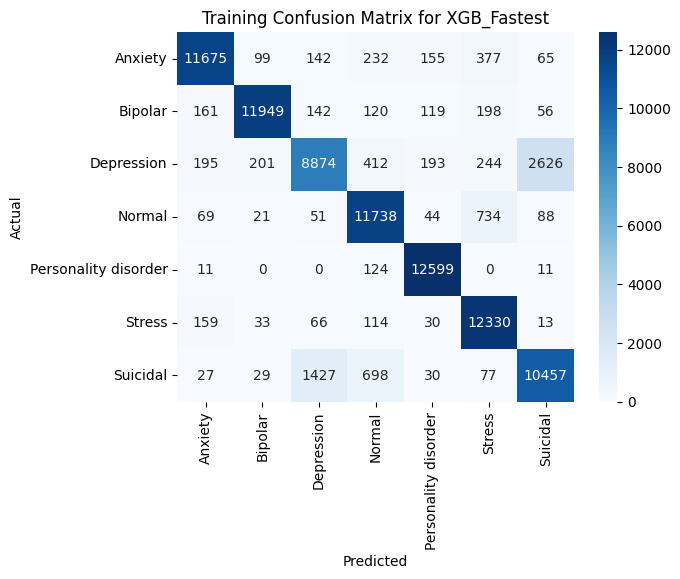


Validation Set Metrics:
                      precision    recall  f1-score   support

             Anxiety       0.83      0.83      0.83       361
             Bipolar       0.78      0.83      0.80       251
          Depression       0.82      0.65      0.72      1521
              Normal       0.92      0.89      0.91      1662
Personality disorder       0.51      0.72      0.60        92
              Stress       0.47      0.84      0.60       224
            Suicidal       0.63      0.73      0.68       996

            accuracy                           0.77      5107
           macro avg       0.71      0.78      0.73      5107
        weighted avg       0.79      0.77      0.78      5107



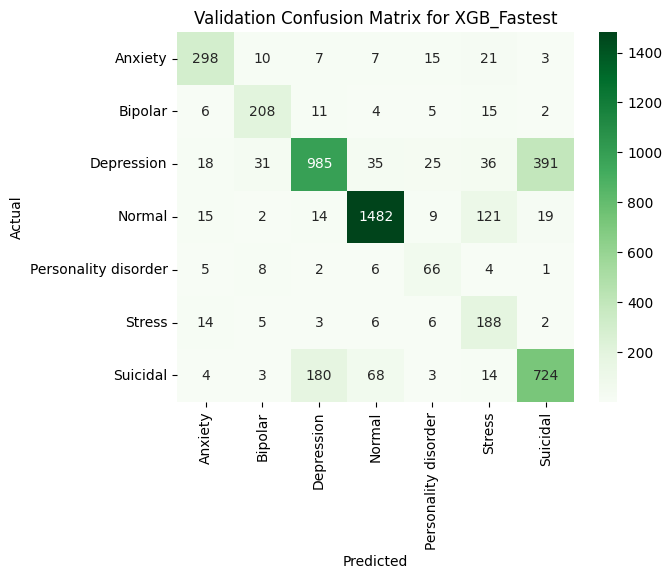


Summary of Accuracy Scores:
XGB_Fastest:
  Training Accuracy: 0.8924732388051336
  Validation Accuracy: 0.7736440180144899
XGB_Fastest:
  Training Accuracy: 0.8924732388051336
  Validation Accuracy: 0.7736440180144899
  Difference: 0.11882922079064373
    Possible Overfitting


In [33]:
# create an empty list to store accuracy scores
accuracy_scores3 = []
training_accuracy_scores3 = []

# create for loop to train, predict, and evaluate each model as well as the training, validation accuracy, confusion matrix and classification report
for name, clf in classifiers3.items():
    clf.fit(X_train_resampled, y_train_resampled)

    # Calculate and store training accuracy
    y_train_pred = clf.predict(X_train_resampled)
    training_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    training_accuracy_scores3.append(training_accuracy)

    # Calculate and store validation accuracy
    y_pred = clf.predict(X_val_combined)
    accuracy = accuracy_score(val_y, y_pred)
    accuracy_scores3.append(accuracy)

    print("\n")
    print(f"For {name}:")
    print(f"  Training Accuracy: {training_accuracy}")
    print(f"  Validation Accuracy: {accuracy}")

    # Compute and display training confusion matrix and classification report
    print("\nTraining Set Metrics:")
    conf_matrix_train = confusion_matrix(y_train_resampled, y_train_pred)
    print(classification_report(y_train_resampled, y_train_pred, target_names=lbl_enc.classes_))

    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Training Confusion Matrix for {name}')
    plt.show()

    # Compute and display validation confusion matrix and classification report
    print("\nValidation Set Metrics:")
    conf_matrix_val = confusion_matrix(val_y, y_pred)
    print(classification_report(val_y, y_pred, target_names=lbl_enc.classes_))

    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Greens', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Validation Confusion Matrix for {name}')
    plt.show()

# Print a summary of accuracy scores at the end
print("\nSummary of Accuracy Scores:")
for i, (name, _) in enumerate(classifiers3.items()):
    print(f"{name}:")
    print(f"  Training Accuracy: {training_accuracy_scores3[i]}")
    print(f"  Validation Accuracy: {accuracy_scores3[i]}")

# (Optional) You can further analyze or compare accuracy scores here for overfitting For example:
for i, (name, _) in enumerate(classifiers3.items()):
    print(f"{name}:")
    print(f"  Training Accuracy: {training_accuracy_scores3[i]}")
    print(f"  Validation Accuracy: {accuracy_scores3[i]}")
    difference = training_accuracy_scores3[i] - accuracy_scores3[i]
    print(f"  Difference: {difference}")  # This would display the difference between the training and validation accuracy
    if difference > 0.1: # difference is greater than 0.1
        print("    Possible Overfitting")
    elif difference < 0.02: # difference is less than 0.02
        print("    Possible Underfitting")
    else:
        print("    Model is likely a good fit")

# MDLC Evaluating on the Test Set the First XGBoost Model




For XGB_Fastest:
  Test Accuracy: 0.7846515270164448

Test Set Metrics:
                      precision    recall  f1-score   support

             Anxiety       0.82      0.84      0.83       377
             Bipolar       0.77      0.84      0.80       257
          Depression       0.83      0.65      0.73      1468
              Normal       0.91      0.90      0.91      1632
Personality disorder       0.54      0.73      0.62       102
              Stress       0.51      0.83      0.64       230
            Suicidal       0.67      0.76      0.71      1042

            accuracy                           0.78      5108
           macro avg       0.72      0.79      0.75      5108
        weighted avg       0.80      0.78      0.79      5108



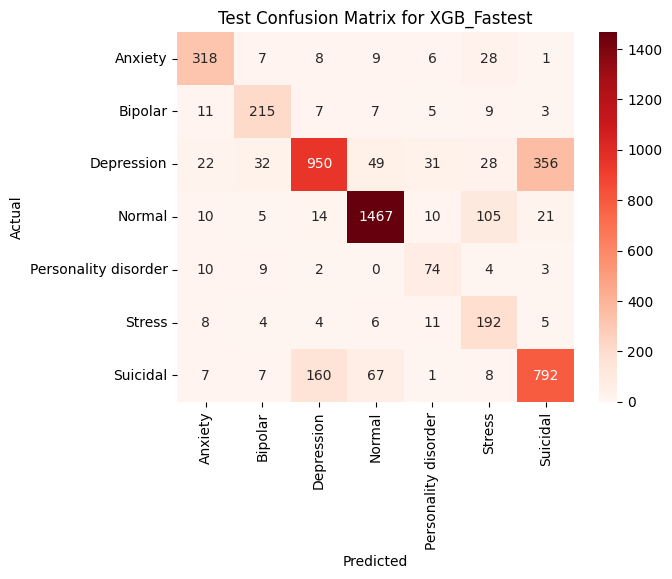

XGB_Fastest:
  Training Accuracy: 0.8924732388051336
  Validation Accuracy: 0.7736440180144899
  Test Accuracy: 0.7846515270164448


In [34]:
# Now evaulate the test set using the best model XGBoost Fastest

# Get the last model from classifiers3
last_model_name, last_model = list(classifiers3.items())[-1]

# Predict on the test set using the last model (using test_x_combined)
y_test_pred = last_model.predict(test_x_combined)

# Calculate and print test accuracy
test_accuracy = accuracy_score(test_y, y_test_pred)
print("\n")
print(f"For {last_model_name}:")
print(f"  Test Accuracy: {test_accuracy}")

# Compute and display test confusion matrix and classification report
print("\nTest Set Metrics:")
conf_matrix_test = confusion_matrix(test_y, y_test_pred)
print(classification_report(test_y, y_test_pred, target_names=lbl_enc.classes_))

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Test Confusion Matrix for {last_model_name}')
plt.show()

# Optional: Compare Training, Validation, and Test scores.
print(f"{last_model_name}:")
print(f"  Training Accuracy: {training_accuracy_scores3[-1]}")
print(f"  Validation Accuracy: {accuracy_scores3[-1]}")
print(f"  Test Accuracy: {test_accuracy}")

# MDLC Step: Conduct Improvements on the Model and Re-evaluate 

We have achieved pretty good accuracy. However, we can use data-centric ai techniques to improve our performance. 

# Data-Centric AI Techniques for Sentiment Analysis in Mental Health  

In our approach to **sentiment analysis for mental health**, we focus on improving the **quality and structure of the dataset** rather than modifying the model itself. Below are three **new Data-Centric AI techniques** we will implement:  

## 1. Adding Statement Length as a Feature  
### **Why It Helps**  
- Longer statements may **contain more context** and emotional depth, which can improve sentiment classification.  
- Shorter statements might be more ambiguous or lack sufficient emotional cues.  
- By including **statement length** as a numerical feature, the model can learn patterns between text length and sentiment, improving overall performance.  

## 2. Using SMOTE Instead of Random Oversampling  
### **Why It Helps**  
- Instead of simple duplication (random oversampling), **SMOTE (Synthetic Minority Over-sampling Technique)** **creates synthetic examples** of the minority class.   This may help with predicting stress and suicidal, which it has a hard time doing. 
- This technique **reduces bias toward majority sentiment classes**, making the model more balanced.  
- For mental health sentiment analysis, where **negative and neutral sentiments** might be underrepresented, **SMOTE ensures these classes have sufficient data for learning**.  

## 3. Removing Outliers from the Data  
### **Why It Helps**  
- **Outliers in sentiment data** could be caused by noisy, irrelevant, or misclassified text (e.g., sarcastic or off-topic responses).  
- Removing outliers **improves the overall consistency of the dataset**, reducing potential confusion for the model especially since the outliers tended to be depression and normal, which have many cases already and create a more balanced dataset. 
- This is especially important in **mental health sentiment analysis**, where extreme or anomalous responses might not align with general sentiment patterns.  

### **Conclusion**  
By focusing on **data quality enhancements**, these techniques aim to **make sentiment predictions more accurate and fair**, ensuring that the model effectively captures mental health-related sentiments in a meaningful way.  


### 1. Removing Outliers from the Data
From the outliers plot way back in the beginning of this notebook, we calculated the outliers for upper and lower bound. We will use those upper and lower bounds and remove them from df_unique.  

In [35]:
df_ai = df_unique[(df_unique['statement_len'] >= lower_bound) & (df_unique['statement_len'] <= upper_bound)]

### 2. Add Statement Length 
When we created our X and y, our training and test data, we dropped the statement length column since they seemed similar to number of characters and number of sentences. We will add it back in now, run the train-test split again and tf-idf. 


In [36]:
X1 = df_ai[['tokens_stemmed', 'num_of_characters', 'num_of_sentences','statement_len']]
y1 = df_ai['status']

In [37]:
# label encode our categorical variables for y 
lbl_enc = LabelEncoder()
y1 = lbl_enc.fit_transform(y1.values)

In [38]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and temporary (20%) sets
train_x1, temp_x1, train_y1, temp_y1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Split the temporary set into validation (50%) and test (50%) sets
val_x1, test_x1, val_y1, test_y1 = train_test_split(temp_x1, temp_y1, test_size=0.5, random_state=42)

# Print the sizes of the splits
print(f"Training set size: {len(train_x1)}")
print(f"Validation set size: {len(val_x1)}")
print(f"Test set size: {len(test_x1)}")

Training set size: 38188
Validation set size: 4773
Test set size: 4774


In [39]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens_stemmed' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf1 = vectorizer.fit_transform(train_x1['tokens_stemmed'])
X_val_tfidf1 = vectorizer.transform(val_x1['tokens_stemmed'])
test_x_tfidf1 = vectorizer.transform(test_x1['tokens_stemmed'])

# 3. Numerical Feature Extraction
X_train_num1 = csr_matrix(train_x1[['num_of_characters', 'num_of_sentences','statement_len']].values)
X_val_num1 = csr_matrix(val_x1[['num_of_characters', 'num_of_sentences','statement_len']].values)
test_x_num1 = csr_matrix(test_x1[['num_of_characters', 'num_of_sentences','statement_len']].values)

# 4. Combine Features
X_train_combined1 = hstack([X_train_tfidf1, X_train_num1])
X_val_combined1 = hstack([X_val_tfidf1, X_val_num1])
test_x_combined1 = hstack([test_x_tfidf1, test_x_num1])

# Print number of feature words
print('Number of feature words:', len(vectorizer.get_feature_names_out()))


Number of feature words: 50000


### 3. Now Use SMOTE instead of Random Oversampling


In [40]:
# View the mapping of categorical labels to numeric labels
print(lbl_enc.classes_)
 # this means anxiety-0, bipolar-1 etc. depression-2, normal-3, personality disorder-4, stress-5, suicidal-6

['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']


In [41]:
# Check the distribution of your target labels for SMOTE
import pandas as pd

df = pd.DataFrame({'status': y1})  # Assuming y1 is your label data
print(df['status'].value_counts())


status
3    16039
2    13440
6     9671
0     3328
1     2229
5     2224
4      804
Name: count, dtype: int64


In [42]:
# Free up memory
import gc
gc.collect()

23986

In [43]:
# Use SMOTE to oversample the training data 
from imblearn.over_sampling import SMOTE
# I would like to add 3000 samples to all classes except 3,2 and 6. I would do more but computationally intensive
sampling_strategy = {
    0: 6328,  # Class 0: 3328 + 3000 = 6328
    1: 5229,  # Class 1: 2229 + 3000 = 5229
    4: 3804,  # Class 4: 804 + 3000 = 3804
    5: 5224   # Class 5: 2224 + 3000 = 5224
}

smote = SMOTE(sampling_strategy = sampling_strategy, random_state=0)
X_train_resampled1, y_train_resampled1 = smote.fit_resample(X_train_combined1,train_y1)

# MDLC Step- Retrain and Re-evaluate on dataset 

In [44]:
# Free up memory
import gc
gc.collect()

0



For XGB_Fastest:
  Training Accuracy: 0.8838867582724662
  Validation Accuracy: 0.7986591242405195

Training Set Metrics:
                      precision    recall  f1-score   support

             Anxiety       0.95      0.93      0.94      6328
             Bipolar       0.97      0.93      0.95      5229
          Depression       0.81      0.80      0.80     10741
              Normal       0.90      0.97      0.93     12855
Personality disorder       0.98      0.96      0.97      3804
              Stress       0.92      0.92      0.92      5224
            Suicidal       0.78      0.73      0.75      7708

            accuracy                           0.88     51889
           macro avg       0.90      0.89      0.90     51889
        weighted avg       0.88      0.88      0.88     51889



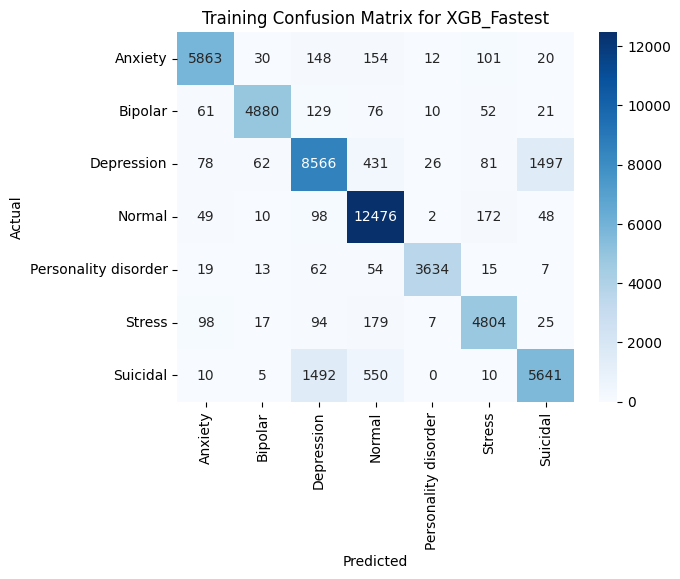


Validation Set Metrics:
                      precision    recall  f1-score   support

             Anxiety       0.82      0.80      0.81       335
             Bipolar       0.83      0.76      0.79       233
          Depression       0.76      0.76      0.76      1307
              Normal       0.88      0.94      0.91      1624
Personality disorder       0.76      0.55      0.64        87
              Stress       0.63      0.65      0.64       231
            Suicidal       0.73      0.68      0.70       956

            accuracy                           0.80      4773
           macro avg       0.77      0.73      0.75      4773
        weighted avg       0.80      0.80      0.80      4773



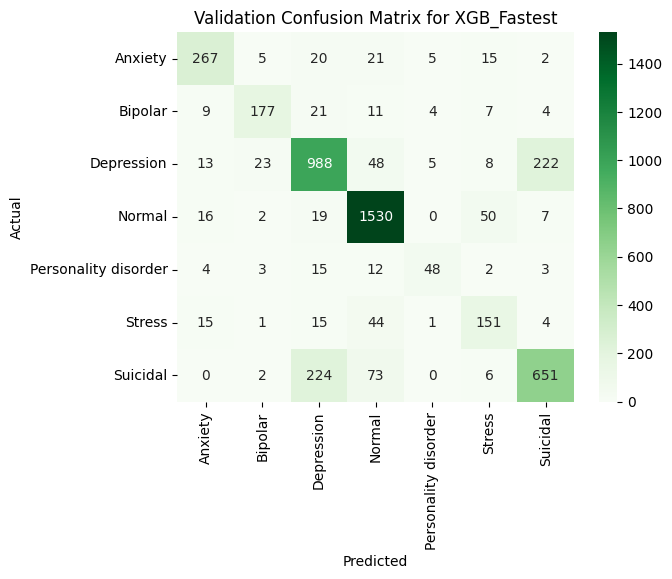


Summary of Accuracy Scores:
XGB_Fastest:
  Training Accuracy: 0.8838867582724662
  Validation Accuracy: 0.7986591242405195
XGB_Fastest:
  Training Accuracy: 0.8838867582724662
  Validation Accuracy: 0.7986591242405195
  Difference: 0.08522763403194666
    Model is likely a good fit


In [45]:
### Now Train Using these new techniques using XGBoost
# create an empty list to store accuracy scores
accuracy_scores4 = []
training_accuracy_scores4 = []

# create for loop to train, predict, and evaluate each model as well as the training, validation accuracy, confusion matrix and classification report
for name, clf in classifiers3.items():
    clf.fit(X_train_resampled1, y_train_resampled1)

    # Calculate and store training accuracy
    y_train_pred = clf.predict(X_train_resampled1)
    training_accuracy = accuracy_score(y_train_resampled1, y_train_pred)
    training_accuracy_scores4.append(training_accuracy)

    # Calculate and store validation accuracy
    y_pred = clf.predict(X_val_combined1)
    accuracy = accuracy_score(val_y1, y_pred)
    accuracy_scores4.append(accuracy)

    print("\n")
    print(f"For {name}:")
    print(f"  Training Accuracy: {training_accuracy}")
    print(f"  Validation Accuracy: {accuracy}")

    # Compute and display training confusion matrix and classification report
    print("\nTraining Set Metrics:")
    conf_matrix_train = confusion_matrix(y_train_resampled1, y_train_pred)
    print(classification_report(y_train_resampled1, y_train_pred, target_names=lbl_enc.classes_))

    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Training Confusion Matrix for {name}')
    plt.show()

    # Compute and display validation confusion matrix and classification report
    print("\nValidation Set Metrics:")
    conf_matrix_val = confusion_matrix(val_y1, y_pred)
    print(classification_report(val_y1, y_pred, target_names=lbl_enc.classes_))

    sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Greens', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Validation Confusion Matrix for {name}')
    plt.show()

# Print a summary of accuracy scores at the end
print("\nSummary of Accuracy Scores:")
for i, (name, _) in enumerate(classifiers3.items()):
    print(f"{name}:")
    print(f"  Training Accuracy: {training_accuracy_scores4[i]}")
    print(f"  Validation Accuracy: {accuracy_scores4[i]}")

# (Optional) You can further analyze or compare accuracy scores here for overfitting For example:
for i, (name, _) in enumerate(classifiers3.items()):
    print(f"{name}:")
    print(f"  Training Accuracy: {training_accuracy_scores4[i]}")
    print(f"  Validation Accuracy: {accuracy_scores4[i]}")
    difference = training_accuracy_scores4[i] - accuracy_scores4[i]
    print(f"  Difference: {difference}")  # This would display the difference between the training and validation accuracy
    if difference > 0.1: # difference is greater than 0.1
        print("    Possible Overfitting")
    elif difference < 0.02: # difference is less than 0.02
        print("    Possible Underfitting")
    else:
        print("    Model is likely a good fit")

### Which Model is better?

The XGBoost model where we did the three new data centric ai techniques performed better than the XGBoost Model we selected last week. This may be because we produced a more balanced dataset by looking at the imbalance and using SMOTE to balance it better as well as removing outliers, which also created a more balanced dataset since it removed a lot of normal and depression ( 2 classes with lots of samples) but not the other classes. It also had a lot less overfitting because the gap between training and validation accuracy was not as big. It also had a higher validation accuracy. It also has higher average recall score.

| Model | Training Accuracy | Validation Accuracy | Validation Recall |
|---|---|---|---|
| XGBoost | 0.89 | 0.77 | 0.77|
| XGBoost SMOTE | 0.88 | 0.80 | 0.80 |

# MDLC Step- Re-evaluate on test dataset



For XGB_Fastest:
  Test Accuracy: 0.7855048177628823

Test Set Metrics:
                      precision    recall  f1-score   support

             Anxiety       0.81      0.82      0.82       302
             Bipolar       0.90      0.77      0.83       224
          Depression       0.74      0.72      0.73      1392
              Normal       0.87      0.95      0.91      1560
Personality disorder       0.72      0.58      0.64        83
              Stress       0.65      0.63      0.64       206
            Suicidal       0.70      0.67      0.68      1007

            accuracy                           0.79      4774
           macro avg       0.77      0.73      0.75      4774
        weighted avg       0.78      0.79      0.78      4774



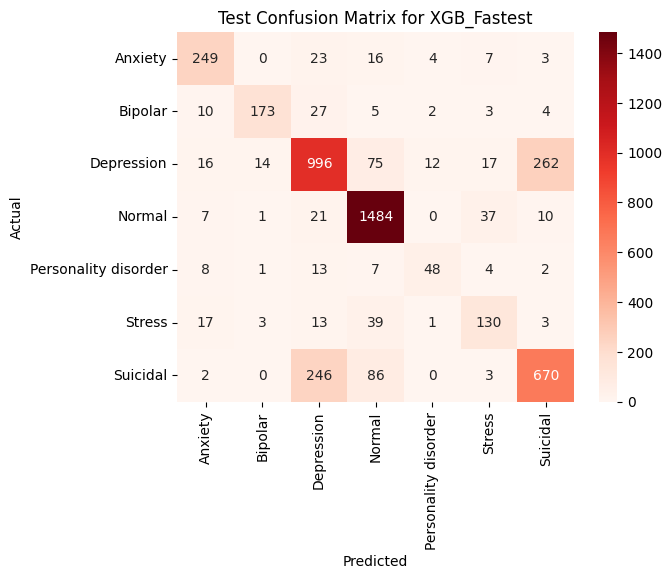

XGB_Fastest:
  Training Accuracy: 0.8838867582724662
  Validation Accuracy: 0.7986591242405195
  Test Accuracy: 0.7855048177628823


In [46]:
# Now evaulate the test set using the best model and the best training and test dataset. 

# Get the last model from classifiers3
last_model_name, last_model = list(classifiers3.items())[-1]

# Predict on the test set using the last model (using test_x_combined)
y_test_pred = last_model.predict(test_x_combined1)

# Calculate and print test accuracy
test_accuracy = accuracy_score(test_y1, y_test_pred)
print("\n")
print(f"For {last_model_name}:")
print(f"  Test Accuracy: {test_accuracy}")

# Compute and display test confusion matrix and classification report
print("\nTest Set Metrics:")
conf_matrix_test = confusion_matrix(test_y1, y_test_pred)
print(classification_report(test_y1, y_test_pred, target_names=lbl_enc.classes_))

sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Reds', xticklabels=lbl_enc.classes_, yticklabels=lbl_enc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Test Confusion Matrix for {last_model_name}')
plt.show()

# Optional: Compare Training, Validation, and Test scores.
print(f"{last_model_name}:")
print(f"  Training Accuracy: {training_accuracy_scores4[-1]}")
print(f"  Validation Accuracy: {accuracy_scores4[-1]}")
print(f"  Test Accuracy: {test_accuracy}")

# MDLC Step Evaluating Bias

#### Feature Importance

1.  **Feature Extraction:** Uses `TfidfVectorizer` for text data (with n-grams) and combines it with numerical features.
2.  **Oversampling:** Applies SMOTE to address class imbalance.
3.  **Model Definition:** We use a dictionary `classifiers3` containing the models to be trained, including 'XGB_Fastest' as an XGBoost classifier, the best model. 
4.  **Feature Importance Extraction for 'XGB_Fastest':** After the training loop, it specifically targets the model named 'XGB_Fastest'. If found, it extracts the `feature_importances_`, maps them to the corresponding feature names (from TF-IDF and numerical features), sorts them, prints the top 20 most important features, and visualizes them using a horizontal bar chart.


#### XGBoost Feature Importance

XGBoost provides a way to estimate the importance of each feature in the trained model. This helps in understanding which features were most influential in making predictions.

**What it Represents:**

* **Relative Contribution:** Feature importance scores indicate the relative contribution of each feature to the model's predictive power. A higher score generally means the feature was more useful.
* **Overall Usefulness:** It reflects how much a feature contributed to improving the model's accuracy across all the boosted trees.
* **Not Directional:** Importantly, feature importance in XGBoost **does not** tell you the direction of the relationship between a feature and the target variable (i.e., whether higher values increase or decrease the prediction).


Top 20 most important features for XGB_Fastest:
bipolar: 0.0239
avpd: 0.0214
with avpd: 0.0186
episod: 0.0126
num_of_characters: 0.0114
im: 0.0105
have avpd: 0.0105
manic: 0.0091
restless: 0.0085
depress: 0.0083
avoid: 0.0075
worri: 0.0075
social: 0.0074
stress: 0.0072
blood: 0.0072
health anxieti: 0.0067
med: 0.0065
lamict: 0.0056
not: 0.0052
stress and: 0.0051


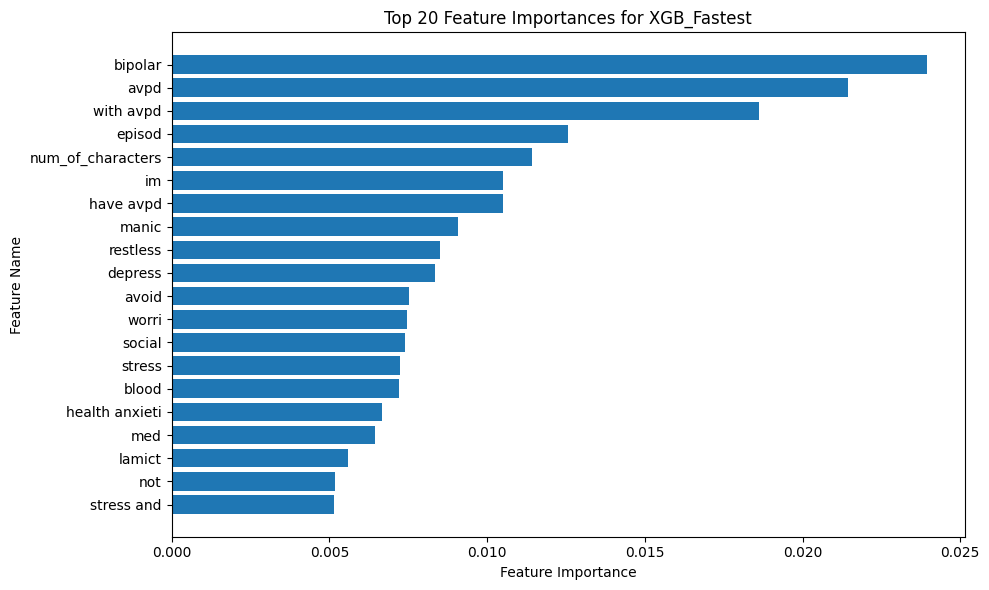

In [47]:

# Assuming classifiers3 is populated and the model name is 'XGB_Fastest'
last_model_name, last_model = list(classifiers3.items())[-1]

# Extract and Display Feature Importances for the model named 'XGB_Fastest'
if last_model_name == 'XGB_Fastest':
    # Get feature importance scores
    importances = last_model.feature_importances_

    # Get feature names for TF-IDF features
    tfidf_feature_names = vectorizer.get_feature_names_out()

    # Get feature names for numerical features
    numerical_feature_names = ['num_of_characters', 'num_of_sentences', 'statement_len']

    # Combine feature names
    all_feature_names = list(tfidf_feature_names) + numerical_feature_names

    # Create a dictionary of feature names and their importance scores
    feature_importance_dict = dict(zip(all_feature_names, importances))

    # Sort feature importances in descending order
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

    # Print the top N important features
    top_n = 20  # You can adjust this number
    print(f"\nTop {top_n} most important features for {last_model_name}:")
    for feature, importance in sorted_feature_importance[:top_n]:
        print(f"{feature}: {importance:.4f}")

    # Visualize feature importances
    plt.figure(figsize=(10, 6))
    top_importances = dict(sorted_feature_importance[:top_n])
    plt.barh(list(top_importances.keys()), list(top_importances.values()))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title(f'Top {top_n} Feature Importances for {last_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
elif hasattr(last_model, 'feature_importances_'):
    print(f"\nExtracting feature importances for the last model: {last_model_name}")
    importances = last_model.feature_importances_
    # Handle feature names based on how the model was trained
    if 'XGB' in last_model_name: # Assuming TF-IDF and numerical features if name contains 'XGB'
        tfidf_feature_names = vectorizer.get_feature_names_out()
        numerical_feature_names = ['num_of_characters', 'num_of_sentences', 'statement_len']
        all_feature_names = list(tfidf_feature_names) + numerical_feature_names
    else:
        # If it's another type of model, you might need a different way to get feature names
        all_feature_names = [f"feature_{i}" for i in range(len(importances))] # Generic names

    feature_importance_dict = dict(zip(all_feature_names, importances))
    sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

    top_n = 20
    print(f"Top {top_n} most important features for {last_model_name}:")
    for feature, importance in sorted_feature_importance[:top_n]:
        print(f"{feature}: {importance:.4f}")

    # Visualization (adapt as needed)
    plt.figure(figsize=(10, 6))
    top_importances = dict(sorted_feature_importance[:top_n])
    plt.barh(list(top_importances.keys()), list(top_importances.values()))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title(f'Top {top_n} Feature Importances for {last_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\nModel '{last_model_name}' does not have a 'feature_importances_' attribute.")

## Interpretation of XGBoost Feature Importance Plot

This horizontal bar plot displays the top 20 most important features as determined by the XGBoost model named "XGB_Fastest". The feature importance is represented by the length of the horizontal bars.

**Key Components:**

* **Y-axis (Feature Name):** Lists the top 20 features that the XGBoost model found to be most influential in making predictions. These features are listed vertically.
* **X-axis (Feature Importance):** Represents the magnitude of each feature's importance. The values increase from left to right. Longer bars indicate higher feature importance.
* **Bars:** Each horizontal bar corresponds to a specific feature. The length of the bar visually represents its importance score.

**Interpretation of the Top Features:**

Based on the plot and the provided numerical values, the top 5 most important features for the "XGB_Fastest" model are:

1.  **bipolar (0.0239):** This is the most important feature by a significant margin. Its presence or characteristics strongly influence the model's predictions.
2.  **avpd (0.0214):** This is the second most important feature, still having a substantial impact on the model's output. "avpd" likely stands for Avoidant Personality Disorder or a related term.
3.  **with avpd (0.0186):** This feature, indicating the presence of "avpd" in some context (likely a phrase or combination with other words), is the third most important.
4.  **episod (0.0126):** This feature, likely related to "episode" (potentially referring to mood episodes or events), is the fourth most important.
5.  **num\_of\_characters (0.0114):** The number of characters in the input text is the fifth most important feature, suggesting that the length of the text provides some predictive signal.

**General Observations:**

* **Dominant Features:** The features "bipolar," "avpd," and "with avpd" appear to be considerably more important than the other features in the top 20. This suggests the model heavily relies on these terms for its predictions.
* **Mental Health Related Terms:** Many of the top features (e.g., bipolar, avpd, episod, manic, depress, avoid, worri, health anxieti, lamict) are directly related to mental health conditions or symptoms. This is expected if the model is designed to classify or analyze text related to mental health.
* **Linguistic Features:** Features like "num\_of\_characters," "im," "have avpd," "not," and "stress and" indicate that the model also considers the presence of specific words, phrases, and the overall length of the text.
* **Relative Importance:** The plot clearly shows the relative importance of each feature compared to the others in the top 20. The differences in bar lengths visually represent the differences in their importance scores.

**Implications:**

Understanding feature importance can be valuable for:

* **Model Interpretation:** Identifying which aspects of the text are most influential in the model's decision-making process.
* **Feature Selection:** Potentially reducing the number of features used in the model if some are consistently low in importance (though caution is needed as seemingly unimportant features can have interactions).
* **Domain Understanding:** Gaining insights into the language and patterns associated with the different categories the model is predicting.
* **Bias Detection (Indirectly):** While this plot alone doesn't directly quantify bias, if you know that certain less important features are strongly associated with specific demographic groups, it might suggest the model isn't relying on those potentially sensitive features as much. However, a dedicated bias analysis using techniques like SHAP would be more direct.

In summary, the "bipolar," "avpd," and "with avpd" terms are the most critical features for the "XGB_Fastest" model according to this analysis, followed by "episod" and the length of the text. The plot provides a clear visual ranking of the top 20 features that contribute most to the model's predictions.

## Quantifying Bias using Recall from a Classification Report (Explanation)

This code analyzes the **recall** metric from a classification report to quantify potential bias in a model's ability to identify different mental health categories. Here's a breakdown of the calculated metrics:

**1. Range of Recall:**

* **Calculation:** The difference between the highest and lowest recall scores observed across all mental health categories.
* **Interpretation:** A **larger range** suggests a greater disparity in the model's ability to correctly identify all instances of different mental health conditions. This indicates that the model is significantly better at recalling some categories than others.

**2. Difference from "Normal" (Baseline) - Recall:**

* **Calculation:** For each mental health category, the recall score is subtracted from the recall score of the "Normal" category (often used as a baseline).
* **Interpretation:**
    * **Larger absolute differences** indicate a greater deviation in recall performance compared to the "Normal" state.
    * A **negative difference** means the model has lower recall for that specific mental health category compared to "Normal" (it misses more actual instances).
    * A **positive difference** (less likely here for mental health categories compared to "Normal") would mean the model has higher recall for that category than for "Normal."

**3. Ratio of Recall to Highest Performing ('Normal'):**

* **Calculation:** The recall score of each mental health category is divided by the highest recall score observed (which is the recall for "Normal" in this case).
* **Interpretation:**
    * Ratios **closer to 1** indicate performance similar to the best-performing category ("Normal").
    * **Lower ratios** indicate poorer recall for that category compared to the best performance, suggesting a potential bias in identifying instances of that specific mental health condition.

**4. Standard Deviation of Recall:**

* **Calculation:** The standard deviation of all the recall scores across the different mental health categories.
* **Interpretation:** A **higher standard deviation** signifies greater variability and inconsistency in the model's recall performance across the different mental health states. This suggests that the model's ability to identify all instances is not uniform across all conditions.

**5. Weighted Average vs. Macro Average (Recall):**

* **Calculation:** The difference between the weighted average recall (which accounts for the number of instances in each category - support) and the macro average recall (which treats each category equally regardless of support).
* **Interpretation:**
    * A **significant positive difference** (weighted average > macro average) suggests that the model achieves better recall on the more frequent (majority) classes. This can indicate a bias where the model is optimized for the conditions with more data and performs worse on less frequent conditions.
    * A **small difference** implies that the class imbalance has less of an impact on the overall recall performance.

**In Summary:**

These calculations provide numerical ways to assess potential bias in your model's ability to correctly identify all instances (recall) of different mental health categories. By analyzing the range, differences from the baseline, ratios, standard deviation, and the comparison of weighted and macro averages for recall, you can gain insights into whether your model's performance is equitable across all mental health conditions or if certain conditions are being under-identified, which can be a critical aspect of bias in this sensitive domain.

In [48]:
# Quantifying Bias 

# Directly provide recall scores for each category from the best model from Week 10 from the test classification report. 
recall_scores_dict = {
    "Anxiety": 0.82,
    "Bipolar": 0.77,
    "Depression": 0.72,
    "Normal": 0.95,
    "Personality disorder": 0.58,
    "Stress": 0.63,
    "Suicidal": 0.67,
}

categories = list(recall_scores_dict.keys())
recall_scores_array = np.array(list(recall_scores_dict.values()))
normal_recall = recall_scores_dict.get("Normal")

if normal_recall is not None:
    # 1. Range of Performance (Recall)
    highest_recall = np.max(recall_scores_array)
    lowest_recall = np.min(recall_scores_array)
    range_recall = highest_recall - lowest_recall
    print(f"Range of Recall: {range_recall:.2f} (Highest: {highest_recall:.2f} for {categories[np.argmax(recall_scores_array)]}, Lowest: {lowest_recall:.2f} for {categories[np.argmin(recall_scores_array)]})")

    # 1. Difference from "Normal" (Baseline) - Recall
    print("\nDifference in Recall from 'Normal' (Baseline):")
    for category, recall in recall_scores_dict.items():
        diff = normal_recall - recall
        print(f"{category}: {diff:.2f}")

    # 1. Ratio of Performance (Recall to Highest)
    print("\nRatio of Recall to Highest Performing ('Normal'):")
    highest_recall_overall = normal_recall
    for category, recall in recall_scores_dict.items():
        ratio = recall / highest_recall_overall
        print(f"{category}: {ratio:.2f}")

    # 1. Standard Deviation of Performance (Recall)
    std_recall = np.std(recall_scores_array)
    print(f"\nStandard Deviation of Recall: {std_recall:.2f}")

    # You would need to manually provide macro and weighted average recall if you're not parsing the full report.
    macro_avg_recall = 0.73  # Replace with the actual macro avg recall
    weighted_avg_recall = 0.79  # Replace with the actual weighted avg recall
    difference_macro_weighted_recall = weighted_avg_recall - macro_avg_recall
    print(f"\nDifference between Weighted and Macro Avg Recall: {difference_macro_weighted_recall:.2f}")
else:
    print("Error: 'Normal' category recall not found in the provided data.")

Range of Recall: 0.37 (Highest: 0.95 for Normal, Lowest: 0.58 for Personality disorder)

Difference in Recall from 'Normal' (Baseline):
Anxiety: 0.13
Bipolar: 0.18
Depression: 0.23
Normal: 0.00
Personality disorder: 0.37
Stress: 0.32
Suicidal: 0.28

Ratio of Recall to Highest Performing ('Normal'):
Anxiety: 0.86
Bipolar: 0.81
Depression: 0.76
Normal: 1.00
Personality disorder: 0.61
Stress: 0.66
Suicidal: 0.71

Standard Deviation of Recall: 0.12

Difference between Weighted and Macro Avg Recall: 0.06


## Interpretation of Bias Based on Recall Metrics

Based on the provided recall metrics, there is evidence of **significant bias** in the model's ability to correctly identify different mental health categories:

**Key Observations Highlighting Potential Bias:**

* **Significant Range of Recall (0.37):** The recall score varies considerably across categories, from a high of 0.95 for "Normal" to a low of 0.58 for "Personality disorder." This wide range indicates the model is much better at identifying some conditions than others, suggesting a bias in its detection capabilities.

* **Large Differences in Recall from "Normal" (Baseline):** Compared to the "Normal" category (recall = 0.95), several mental health conditions show substantial deficits in recall:
    * **Personality disorder: -0.37**
    * **Stress: -0.32**
    * **Suicidal: -0.28**
    * **Depression: -0.23**
    * **Bipolar: -0.18**
    * **Anxiety: -0.13**
    This indicates the model misses a significant proportion of actual cases for these conditions compared to the "Normal" state. The large negative differences for "Personality disorder," "Stress," and "Suicidal" are particularly concerning due to the potential severity of false negatives.

* **Low Ratios of Recall to "Normal":** The recall performance relative to the best-performing category ("Normal") is low for several conditions:
    * **Personality disorder: 0.61** (Recall is only 61% of "Normal")
    * **Stress: 0.66**
    * **Suicidal: 0.71**
    * **Depression: 0.76**
    * **Bipolar: 0.81**
    * **Anxiety: 0.86**
    These ratios highlight that the model is considerably less effective at recalling instances of these mental health conditions compared to "Normal."

* **Non-Negligible Standard Deviation (0.12):** The standard deviation of 0.12 in recall scores across categories indicates a considerable spread in the model's performance. This lack of consistency suggests bias, as the model's ability to correctly identify instances varies significantly depending on the mental health category.

* **Positive Difference Between Weighted and Macro Average Recall (0.06):** The weighted average recall is higher than the macro average recall. This suggests that the model performs better on the more frequent categories in the dataset (likely "Normal" and "Depression" based on typical class distributions in such tasks). This indicates a potential bias towards the majority classes, where the model might be better at recalling them simply due to having more training examples.

**Conclusion on Bias:**

The provided recall metrics clearly demonstrate **significant bias** in the model's ability to identify different mental health categories. The model exhibits:

* **Substantial under-detection (low recall) for "Personality disorder," "Stress," and "Suicidal"**, which can have serious real-world consequences.
* **Potential bias against less frequent categories**, as indicated by the lower recall and the difference between weighted and macro average recall.
* **Over-performance on the "Normal" category**, potentially due to its higher representation in the data.

Addressing this bias is crucial for ensuring the model is fair, reliable, and effective in a real-world application where accurate identification of all mental health states is important. Further investigation into the reasons for these disparities and the implementation of bias mitigation techniques are necessary.

## Addressing Potential Bias (Note on Mitigation)

The observed bias in recall performance across different mental health categories, particularly the under-detection of "Personality disorder," "Stress," and "Suicidal," could potentially be addressed through techniques aimed at balancing the class distribution in the training data.

**Note on SMOTE:**

One such technique is SMOTE (Synthetic Minority Over-sampling Technique). SMOTE works by creating synthetic instances of the minority classes, effectively increasing their representation in the training data. This can help the model learn to better identify instances of these less frequent categories, potentially improving their recall.

**Computational Limitations:**

However, as noted, applying SMOTE to the entire dataset in the current JupyterLab environment proved to be computationally intensive and led to crashes. This suggests that the available resources (likely CPU and RAM) are insufficient for handling the increased data size and complexity that SMOTE introduces, especially with a potentially large original dataset.

**Potential with GPU Access:**

Given access to GPUs (Graphics Processing Units) within this environment, the computational limitations associated with SMOTE and similar oversampling techniques could likely be overcome. GPUs are highly parallel processors that can significantly accelerate the computations involved in training machine learning models on larger and more balanced datasets. With GPU acceleration, it would be feasible to:

* **Apply SMOTE effectively:** Generate synthetic samples for the minority mental health categories without crashing the environment.
* **Retrain the model:** Train a new model on the more balanced dataset, allowing it to learn more robust representations for all categories and potentially reduce the observed bias in recall.

**Conclusion on Mitigation:**

While SMOTE presents a viable strategy for addressing the identified bias, its practical application in the current environment is limited by computational constraints. With access to GPUs, the computational intensity of oversampling techniques like SMOTE could be managed, paving the way for a more balanced and potentially less biased model in predicting different mental health categories.

# MDLC Step Saving and Packaging Model for Deployment

Now we will save our model as a pickle file so we can deploy it. 

In [50]:
import pickle
# Create the 'models' folder if it doesn't exist
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# save pickle file
model_filename = f"{last_model_name.replace(' ', '_').lower()}_xgboost_model.pkl"
model_filepath = os.path.join(models_dir, model_filename) #changed model_filename to model_filepath
with open(model_filepath, 'wb') as file:
    pickle.dump(last_model, file)
print(f"Model saved to {model_filepath}") #changed model_filename to model_filepath

Model saved to models/xgb_fastest_xgboost_model.pkl


In [51]:
# --- How to load the saved pickle file ---
# To load the saved model later:
with open(model_filepath, 'rb') as file: #changed model_filename to model_filepath
    loaded_model = pickle.load(file)

print(f"Model '{model_filename}' loaded successfully!")

Model 'xgb_fastest_xgboost_model.pkl' loaded successfully!
